<h1>
    Ciencia de datos e inferencia estadística (Ago 19 Gpo 1): <br>
    <b>Case Study 01</b>
</h1>

<table width="75%" align="center">
    <tr>
        <th align="left" colspan="2">
            <h2><b>Code Players</b> (aka. Team 11)<b>:</b></h2>
        </th>
    </tr>
    <tr>
        <td><h3>Antonio Osamu Katagiri Tanaka</h3></td>
        <td><h4>A01212611@itesm.mx</h4></td>
    </tr>
    <tr>
        <td><h3>Diego Sebastián Ceciliano Franco</h3></td>
        <td><h4>A01373414@itesm.mx</h4></td>
    </tr>
    <tr>
        <td><h3>Carlos Cardoso Isidoro</h3></td>
        <td><h4>A01750267@itesm.mx</h4></td>
    </tr>
    <tr>
        <td><h3>Jesús Alberto Martínez Espinosa</h3></td>
        <td><h4>A01750270@itesm.mx</h4></td>
    </tr>
</table>

<h1>Chapter 06 - <b>Empirical Bayes</b>.</h1>
<h2>Efron, B., & Hastie, T. (2017). <b>Computer Age Statistical Inference</b>.</h2>

### Setup

In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.signal as sg
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)

from matplotlib import colors as mcolors
from matplotlib.collections import LineCollection
from math import factorial, log
from scipy import special, optimize
from IPython.display import display, Image

In [2]:
# R PACKAGES
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri as rpyn
#import rpy2.robjects.lib.ggplot2 as ggplot2

from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.vectors import IntVector
#from rpy2.robjects.rinterface.globalenv import get as py_get
#from rpy2.robjects.lib import grdevices

package_names = {'deconvolveR'}

if all(rpackages.isinstalled(x) for x in package_names):
    have_package = True;
else:
    have_package = False;
if not have_package:
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    packnames_to_install = [x for x in package_names if not rpackages.isinstalled(x)]
    if len(packnames_to_install) > 0:
        utils.install_packages(StrVector(packnames_to_install))
        
deconvolveR = robjects.packages.importr('deconvolveR')
pandas2ri.activate()

---
# 6.1 Robbins' Formula

### Data

In [120]:
counts = dict(enumerate([7840, 1317, 239, 42, 14, 4, 4, 1]));
print(counts);

{0: 7840, 1: 1317, 2: 239, 3: 42, 4: 14, 5: 4, 6: 4, 7: 1}


### Robbins' formula calculations

#### Empirical version

$$ \hat{E} \{\theta | x\} = \frac{(x + 1) \hat{f}(x + 1)}{\hat{f}(x)} = \frac{(x + 1) y_{x + 1}}{y_x} $$

In [121]:
formula6p7 = [0] * (len(counts) - 1);
for i in range(len(counts) - 1):
    formula6p7[i] = ((i + 1) * counts[i + 1] / counts[i]);

#### Gamma-prior version

$$ g(\theta) = \frac{\theta^{\nu - 1} \epsilon^{-\frac{\theta}{\sigma}}}{\sigma^{\nu} \Gamma (\nu)} \text{, for } \theta \geq 0 $$

In [122]:
def f(x, nu, sigma):
    gamma = sigma / (1 + sigma);
    numer = gamma ** (nu + x) * special.gamma(nu + x);
    denom = sigma ** nu * special.gamma(nu) * factorial(x);
    return numer / denom;

parameters $\nu$ and $\sigma$ unknown. Estimates $(\hat{\nu}, \hat{\sigma})$ are obtained by maximum likelihood fitting to the counts yx

In [123]:
def negloglikelihood(params):
    nu, sigma = params;
    summation = 0;
    
    for x in range(len(counts)):
        summation += (counts[x] * log(f(x, nu, sigma)));
    
    return -summation;

results = optimize.minimize(
    negloglikelihood,
    x0 = [0.5, 1.0],
    bounds=[[0, None], [0, None]]
);

print(results);
nu, sigma = results.x;

      fun: 5348.039959663243
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02601155, -0.05820766])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 15
   status: 0
  success: True
        x: array([0.7015099 , 0.30555692])


function to compute: $\gamma^{MLE}$
$$ \gamma^{MLE} = \frac{(x + 1) \hat{f}(x + 1)}{\hat{f}(x)} $$

In [124]:
def gamma_mle_(counts, nu, sigma):
    gamma_mle = [0] * (len(counts) - 1);
    
    for x in range(len(counts) - 1):
        gamma_mle[x] = (x + 1) * f(x + 1, nu, sigma) / f(x, nu, sigma);
    
    return gamma_mle;

### Table 6.1

In [125]:
gamma_mle = gamma_mle_(counts, nu, sigma);

tmplt_int = "  ".join(["{:<14}"] + ["{:>5}"]*8);
tmplt_flt = "  ".join(["{:<14}"] + ["{:>#5.3g}"]*7);

print(tmplt_int.format("Claims x", *list(range(8))));
print("-" * 70);
print(tmplt_int.format('Counts y_x', *counts.values(), 0));
print(tmplt_flt.format('Formula (6.7)', *formula6p7, 0));
print(tmplt_flt.format('Gamma MLE', *gamma_mle, 0));

Claims x            0      1      2      3      4      5      6      7
----------------------------------------------------------------------
Counts y_x       7840   1317    239     42     14      4      4      1
Formula (6.7)   0.168  0.363  0.527   1.33   1.43   6.00   1.75
Gamma MLE       0.164  0.398  0.632  0.866   1.10   1.33   1.57


### Figure 6.1

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

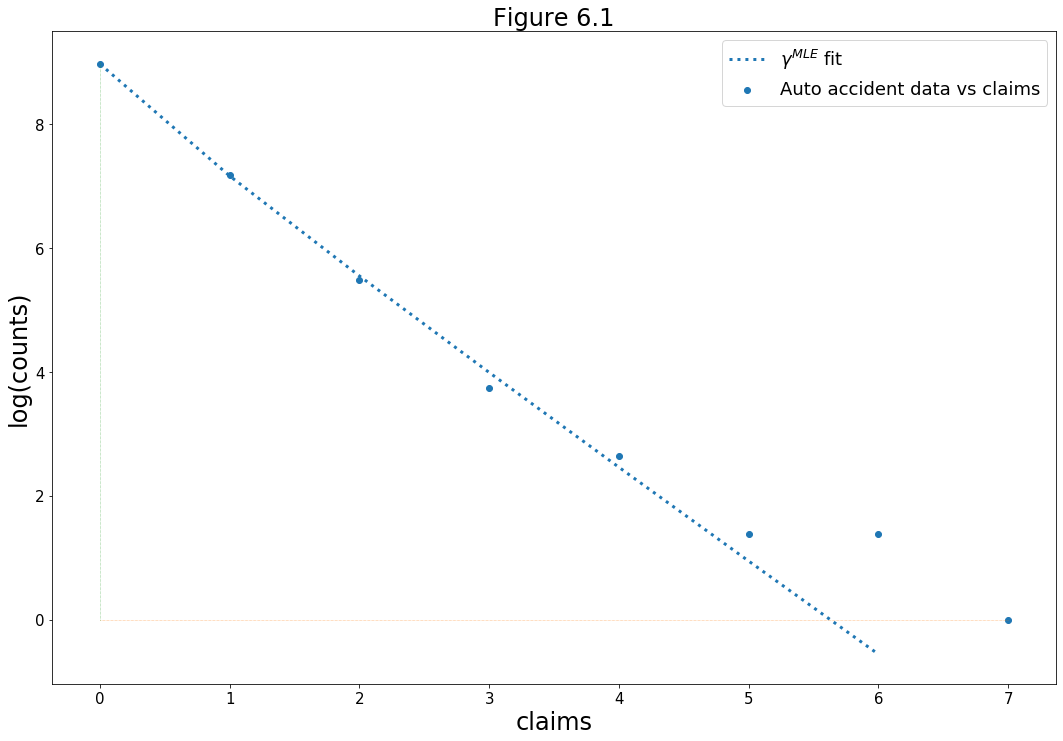

In [126]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));

# Calculate the number of events
n_events = 0;
for claims, count in counts.items():
    n_events += count;

# Compute the gamma_mle fit
n_counts = len(counts);
gamma_mle_fit = [0] * (n_counts - 1);
for x in range(n_counts - 1):
    gamma_mle_fit[x] = log(n_events * f(x, nu, sigma));

# Compute log(counts)
log_counts = [0] * (n_counts);
for x in range(n_counts):
    log_counts[x] = log(counts[x]);

# Plot
plt.plot(range(n_counts-1), gamma_mle_fit, ':', linewidth=3, label=r'$\gamma^{MLE}$' + ' fit');
plt.scatter(range(n_counts), log_counts, label='Auto accident data vs claims');

# Origin axis
Xzeros = np.linspace(0, 0, n_counts);
plt.plot(range(n_counts), Xzeros, ':', linewidth=0.5);
Yzeros = np.linspace(0, 0, n_counts+2);
plt.plot(Yzeros, range(n_counts+2), ':', linewidth=0.5);

# Display plots
plt.yscale('linear');
plt.xlabel('claims', fontsize=24);
plt.ylabel('log(counts)', fontsize=24);
plt.title('Figure 6.1', size=24);
plt.legend(prop={'size': 18});
display(plt);

---
# 6.2 The Missing-Species Problem

### Data

In [127]:
butterflies_df = pd.read_csv("./data/butterfly.txt", delimiter=" ", index_col="x");

### Table 6.2

In [128]:
n_butterflies_df = len(butterflies_df);
nHalf_butterflies_df = int(n_butterflies_df/2);

tmplt_int = "  ".join(["{:<5}"] + ["{:>3}"]*nHalf_butterflies_df);

butterflies_lst1 = [butterflies_df.iat[i, 0] for i in range(0,nHalf_butterflies_df)];
butterflies_lst2 = [butterflies_df.iat[i, 0] for i in range(nHalf_butterflies_df,n_butterflies_df)];

print(tmplt_int.format("x", *range(1, nHalf_butterflies_df+1)));
print("-" * 65);
print(tmplt_int.format('y', *butterflies_lst1));
print("\n");
print(tmplt_int.format("x", *range(nHalf_butterflies_df+1, n_butterflies_df+1)));
print("-" * 65);
print(tmplt_int.format('y', *butterflies_lst2));

x        1    2    3    4    5    6    7    8    9   10   11   12
-----------------------------------------------------------------
y      118   74   44   24   29   22   20   19   20   15   12   14


x       13   14   15   16   17   18   19   20   21   22   23   24
-----------------------------------------------------------------
y        6   12    6    9    9    6   10   10   11    5    3    3


### Table 6.3

$$ \hat{E}(t) = y_1 t - y_2 t^2 + y_3 t^3 - \ldots $$

In [129]:
def nonpar_bayes(butterflies, t):
    result = 0.0;

    for n_times, row in butterflies.iterrows():
        n_butterflies = row["y"];
        
        # multiply (-1)**(n_times - 1) as the sign is positive
        # for odd indexes and negative for even indexes
        
        result += (-1)**(n_times - 1) * n_butterflies * t**n_times;
    return result;

$$ \hat{sd}(t) = \left(\sum _{x=1}^{24} y_x t^{2x}\right)^{\frac{1}{2}} $$

In [130]:
def sd_hat(butterflies, t):
    variance = 0.0;
    
    for n_times, row in butterflies.iterrows():
        n_butterflies = row["y"];
        
        '''The sd_hat(t) values do not match table 6.3 from the book.
        If the exponent is changed from '2 * n_times' to just 2,
        then the values match:'''
        #variance += n_butterflies * t**(2 * n_times);
        variance += n_butterflies * t**(2);
        
    return np.sqrt(variance);

In [131]:
t = np.linspace(0.0, 1, 11);
n_t = len(t);

i_count = 0;
nonpar_vals = [0] * n_t;
for i in t:
    nonpar_vals[i_count] = nonpar_bayes(butterflies_df, i);
    i_count += 1;

i_count = 0;
sd_hat_vals = [0] * n_t;
for i in t:
    sd_hat_vals[i_count] = sd_hat(butterflies_df, i);
    i_count += 1;

In [132]:
tmplt_t = "  {:>5.1f}" * n_t;
tmplt = "  {:>5.2f}" * n_t;

print("        t" + tmplt_t.format(*t));
print("-" * 86);
print("     E(t)" + tmplt.format(*nonpar_vals));
print("sd_hat(t)" + tmplt.format(*sd_hat_vals));

        t    0.0    0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9    1.0
--------------------------------------------------------------------------------------
     E(t)   0.00  11.10  20.96  29.79  37.79  45.17  52.15  58.93  65.57  71.56  75.00
sd_hat(t)   0.00   2.24   4.48   6.71   8.95  11.19  13.43  15.67  17.91  20.14  22.38


### Figure 6.2

$$ E(t) = \frac{e_1 \left\{ 1 - (1 + \gamma t)^{-\nu} \right\}}{\gamma \nu} $$

In [133]:
def par_bayes(butterflies_df, t):
    nu = 0.104;
    sigma = 89.79;
    gamma = sigma / (1 + sigma);
    
    numer = butterflies_df.iloc[0]['y'] * (1 - (1 + gamma * t)**(-nu));
    denom = gamma * nu;
    return  numer / denom;

In [134]:
# Calculate the parametric empirical Bayes estimates
par_vals = [0] * n_t
i_count = 0;
for i in t:
    par_vals[i_count] = par_bayes(butterflies_df, i);
    i_count += 1;

In [135]:
# Calculate the non-parametric empirical Bayes estimates
# standard deviation lines
sd_lines = LineCollection([
    [[t, exp - sd], [t, exp + sd]]
    for t, exp, sd in zip(t, nonpar_vals, sd_hat_vals)
])

In [136]:
# Calculate the Gamma model values for t = 2, 4, and 8
beyond_t = (2, 4, 8);
n_exp = [0] * len(beyond_t)
i_count = 0;
for i in beyond_t:
    n_exp[i_count] = int(round(par_bayes(butterflies_df, i)))
    i_count += 1;

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

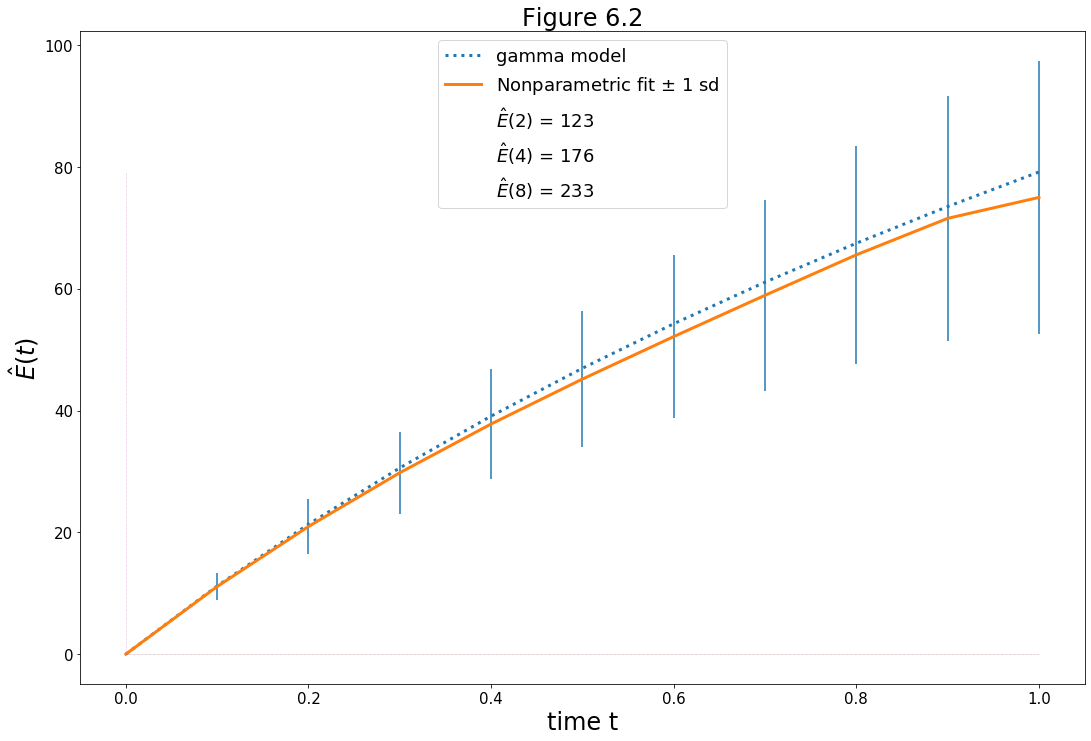

In [144]:
scale = 6;
fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

# Plot
plt.plot(t, par_vals, ':', linewidth=3, label='gamma model');
plt.plot(t, nonpar_vals, '-', linewidth=3, label='Nonparametric fit ' + r'$\pm$' + ' 1 sd');
ax.add_collection(sd_lines)

# Legends for the Gamma model values for t = 2, 4, and 8
i_count = 0;
for i in beyond_t:
    plt.plot(0, 0, '-', linewidth=0, label=r'$\hat{E}$(' + str(i) + ') = ' + str(n_exp[i_count]));
    i_count += 1;

# Origin axis
Xzeros = np.linspace(0, 0, len(par_vals));
plt.plot(np.linspace(min(t), max(t), len(par_vals)), Xzeros, ':', linewidth=0.5);
Yzeros = np.linspace(0, 0, len(t));
plt.plot(Yzeros, np.linspace(min(par_vals), max(par_vals), len(t)), ':', linewidth=0.5);

# Display plots
plt.yscale('linear');
plt.xlabel('time t', fontsize=24);
plt.ylabel(r'$\hat{E}(t)$', fontsize=24);
plt.title('Figure 6.2', size=24);
plt.legend(prop={'size': 18});
display(plt);

### Table 6.4

### Data

In [32]:
shakespeare_df = pd.read_csv("./data/shakespeare.txt", delimiter=" ");

In [33]:
n = np.linspace(1, 10, 10);
tmplt = "   {:<5}" * len(n);

print("         " + tmplt.format(*n));
print("-" * 90);
i_count = 0;
for i in range(len(n)):
    window = 10;
    shakespeare_lst = list(shakespeare_df.iloc[i_count*window:i_count*window+10]['count']);
    print("     " + str(i_count*max(n)) + '+' + tmplt.format(*shakespeare_lst));
    i_count += 1;

            1.0     2.0     3.0     4.0     5.0     6.0     7.0     8.0     9.0     10.0 
------------------------------------------------------------------------------------------
     0.0+   14376   4343    2292    1463    1043    837     638     519     430     364  
     10.0+   305     259     242     223     187     181     179     130     127     128  
     20.0+   104     105     99      112     93      74      83      76      72      63   
     30.0+   73      47      56      59      53      45      34      49      45      52   
     40.0+   49      41      30      35      37      21      41      30      28      19   
     50.0+   25      19      28      27      31      19      19      22      23      14   
     60.0+   30      19      21      18      15      10      15      14      11      16   
     70.0+   13      12      10      16      18      11      8       15      12      7    
     80.0+   13      12      11      8       10      11      7       12      9       8    
 

---
# 6.3 A Medical Example

### Data

In [3]:
nodes_df = pd.read_csv("./data/nodes.txt", delimiter=" ");

### Figure 6.3

$$ p_k = \frac{x_k}{n_k} \text{ , where } k = 1, 2, \dots, N $$

In [4]:
nodes_x = nodes_df.iloc[:]['x'];
nodes_n = nodes_df.iloc[:]['n'];
nodes_p = nodes_x/nodes_n;

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

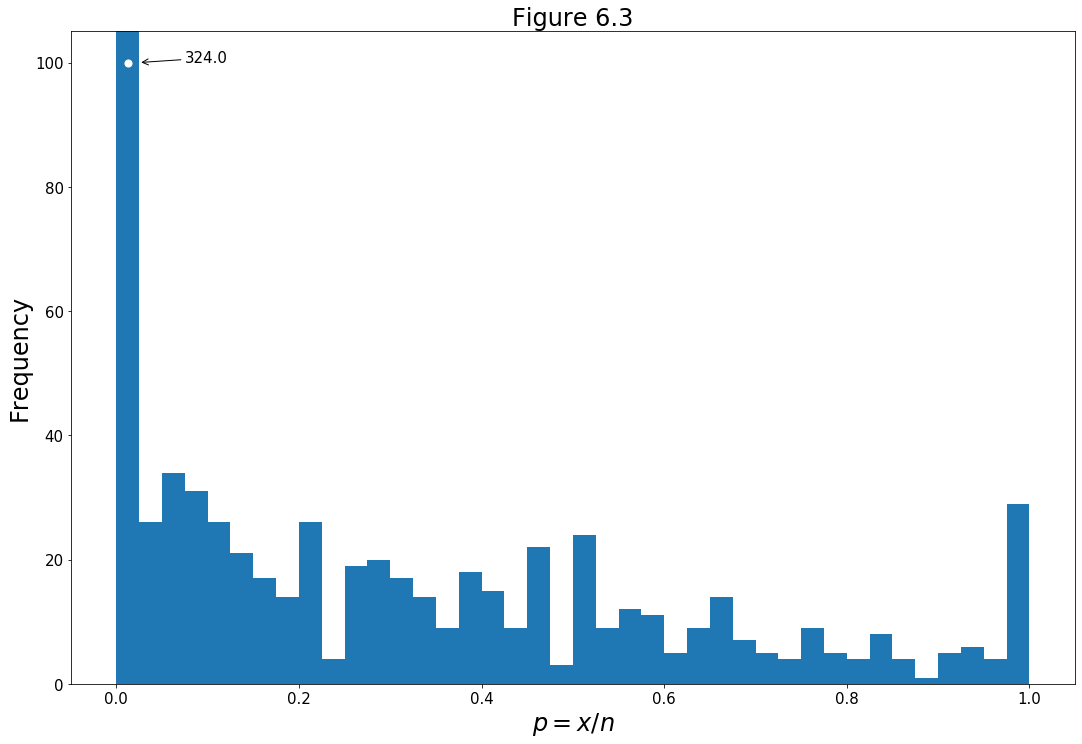

In [5]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));

# Plot
n_bins = 40;
y, x, _ = plt.hist(nodes_p, bins=n_bins, zorder=0);
plt.scatter((x[1]-x[0])/2, 100, color='white', s=50, zorder=1);

# Display plots
plt.yscale('linear');
plt.xlabel(r'$p = x/n$', fontsize=24);
plt.ylabel('Frequency', fontsize=24);
plt.title('Figure 6.3', size=24);
plt.ylim(0,105);
plt.annotate(str(max(y)),
             xy=((2*x[1]+x[0])/2,100),
             xytext=(x[3],100),
             arrowprops=dict(arrowstyle="->"),
             fontsize=15);
display(plt);

### Figure 6.4

$$ f_\alpha(x_k) = \int_0^1 \left(
\begin{array}{c}
 n_k \\
 x_k \\
\end{array}
\right) \theta^{x_k} (1 - \theta)^{n_k - x_k} g_\alpha(\theta) d \theta $$

$$ \hat{\alpha} = \overset{\text{arg max}}{\alpha} \left\{ \sum _{k=1}^{N} Log f_\alpha(x_k) \right\} $$

$$ Log\{g_\alpha(\theta)\} = a_0 + \sum _{j=1}^{4} \alpha_j \theta^j $$

In [33]:
theta = np.linspace(0.01, 0.99, 99);
result = deconvolveR.deconv(tau = theta, X = nodes_df, family = "Binomial", c0 = 1)
#display(result.names)

d = result[6]; #stats
#print(d)
g = d.rx(True, 2) #extract 2nd column
SE_g = d.rx(True, 3) #extract 3rd column
G = d.rx(True, 4) #extract 4th column
indices = np.linspace(1, 97, 49).astype(int);

# convert rpy2.robjects.vectors.FloatVector to numpy.ndarray
g = np.array(g)
SE_g = np.array(SE_g)

# refs:
# --------
# http://statweb.stanford.edu/~ckirby/brad/papers/2016G-ModelingProgram.pdf
# https://cran.r-project.org/web/packages/deconvolveR/vignettes/deconvolution.html
# https://www.youtube.com/watch?v=GvmoOHkABNA

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

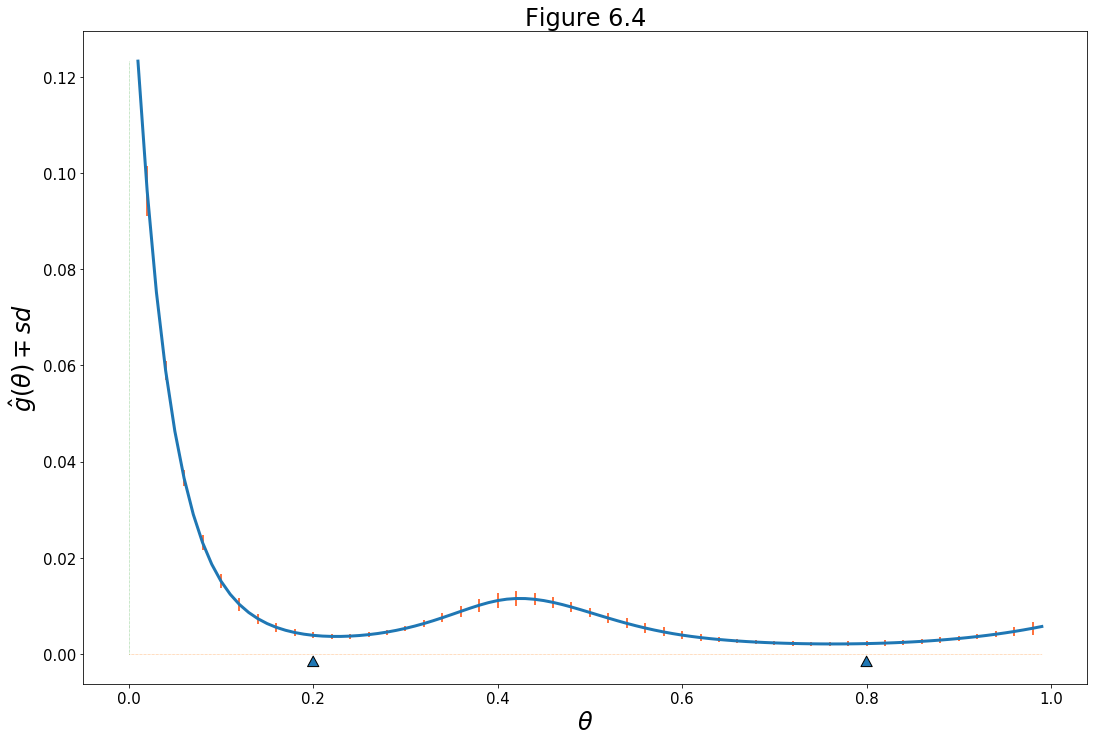

In [7]:
scale = 6;
fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

# Plot
plt.plot(theta, g, '-', linewidth=3, label='gamma model');

# sd_lines
colors = mcolors.to_rgba('orangered')
sd_lines = LineCollection(
    [[[theta, exp - sd], [theta, exp + sd]]
    for theta, exp, sd in zip(theta[indices], g[indices], SE_g[indices])],
    colors=colors, linestyle='solid'
)
ax.add_collection(sd_lines)

# Origin axis
Xzeros = np.linspace(0, 0, len(g));
plt.plot(np.linspace(0, max(theta), len(g)), Xzeros, ':', linewidth=0.5);
Yzeros = np.linspace(0, 0, len(theta));
plt.plot(Yzeros, np.linspace(0, max(g), len(theta)), ':', linewidth=0.5);

# Display plots
plt.yscale('linear');
plt.xlabel(r'$\theta$', fontsize=24);
plt.ylabel(r'$\hat{g}(\theta) \mp sd$', fontsize=24);
plt.title('Figure 6.4', size=24);
#plt.legend(prop={'size': 18});
plt.annotate('',
             xy=(0.2,0.0),
             xytext=(0.2,-0.003),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.75"),
             fontsize=15);
plt.annotate('',
             xy=(0.8,0.0),
             xytext=(0.8,-0.003),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.75"),
             fontsize=15);
display(plt);

### Figure 6.5

$$ f_\alpha (n_i, x_i) = \int_0^1 \left(
\begin{array}{c}
 n_i \\
 x_i \\
\end{array}
\right) \theta^{x_i} (1 - \theta)^{n_i - x_i} g_\alpha (\theta) \, d\theta $$

In [35]:
def f_alpha(x_k, n_k):
    r.assign("r_x_k", x_k)
    r.assign("r_n_k", n_k)
    
    Binom = robjects.r('dbinom(x = r_x_k, size = r_n_k, prob = r_theta)')
    r.assign("r_Binom", Binom)
    
    # 0.01 is the delta_theta in the Riemann sum
    Sum = robjects.r('sum(r_Binom * r_G) * 0.01')    
    return Sum[0]

$$ \hat{g} (\theta | x_i, n_i) = \frac{g_{\hat{\alpha}} (\theta) \left(
\begin{array}{c}
 n_i \\
 x_i \\
\end{array}
\right) \theta^{x_i} (1 - \theta)^{n_i - x_i}}{f_\hat{\alpha} (n_i, x_i)}  $$

In [36]:
# g_theta_hat <- function(n_k, x_k) {
#     gTheta * dbinom(x = x_k, size = n_k, prob = theta) / f_alpha(n_k, x_k)
# }
def g_theta_hat(x_k, n_k):
    r.assign("r_x_k", x_k)
    r.assign("r_n_k", n_k)
    
    f_alpha_val = f_alpha(x_k, n_k);
    r.assign("r_f_alpha_val", f_alpha_val)
    
    numer = robjects.r('r_G * dbinom(x = r_x_k, size = r_n_k, prob = r_theta)')
    denom = f_alpha_val
    return  numer / denom;
    #return robjects.r('r_G * dbinom(x = r_x_k, size = r_n_k, prob = r_theta) / r_f_alpha_val')

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

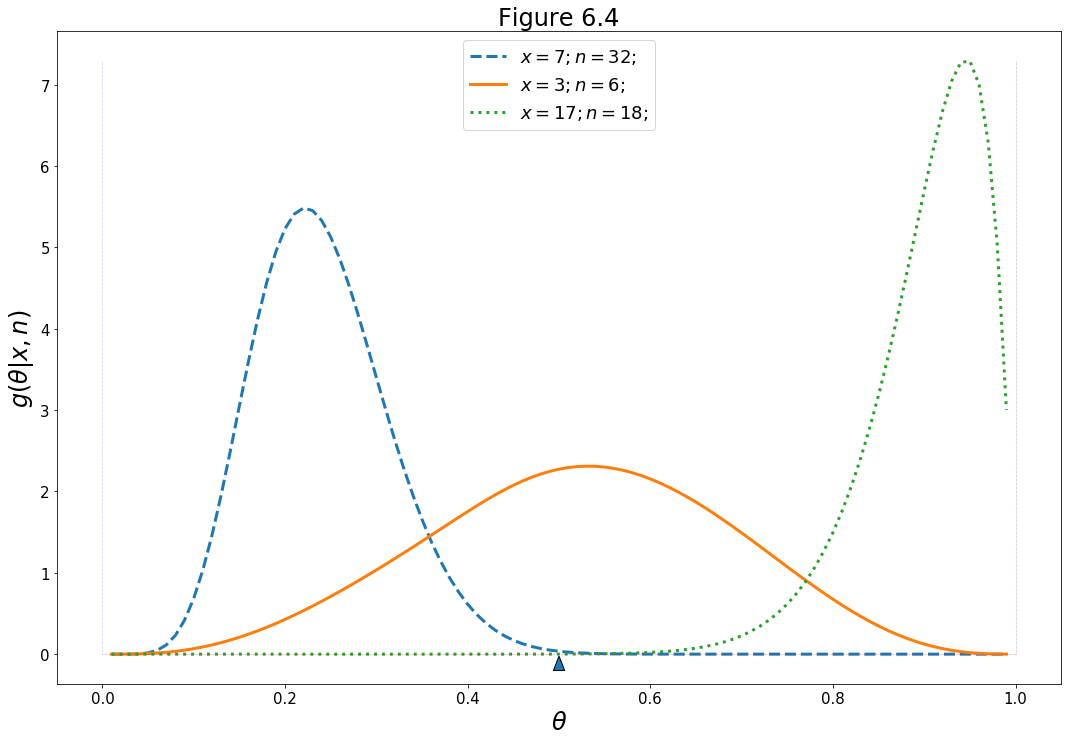

In [37]:
r.assign("r_theta", theta)
r.assign("r_G", G)

scale = 6;
fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

# Plot
g_1 = g_theta_hat( 7, 32)
g_2 = g_theta_hat( 3,  6)
g_3 = g_theta_hat(17, 18)

plt.plot(theta, g_1, '--', linewidth=3, label=r'$x=7;n=32;$');
plt.plot(theta, g_2, '-', linewidth=3, label=r'$x=3;n=6;$');
plt.plot(theta, g_3, ':', linewidth=3, label=r'$x=17;n=18;$');

# Origin axis
Xzeros = np.linspace(0, 0, len(g_3));
plt.plot(np.linspace(0, 1, len(g_3)), Xzeros, ':', linewidth=0.5);
Yzeros = np.linspace(0, 0, len(theta));
plt.plot(Yzeros, np.linspace(0, max(g_3), len(theta)), ':', linewidth=0.5);
Yones = np.linspace(1, 1, len(theta));
plt.plot(Yones, np.linspace(0, max(g_3), len(theta)), ':', linewidth=0.5);

# Display plots
plt.yscale('linear');
plt.xlabel(r'$\theta$', fontsize=24);
plt.ylabel(r'$g(\theta | x, n)$', fontsize=24);
plt.title('Figure 6.4', size=24);
plt.legend(prop={'size': 18});
plt.annotate('',
             xy=(0.5,0.0),
             xytext=(0.5,-0.225),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.75"),
             fontsize=15);
display(plt);